# Proximity tools

In this tutorial, you'll learn how to use [Xarray-Spatial's proximity toolset](https://xarray-spatial.org/user_guide/proximity.html) to measure distances between points. You'll use the [European Commission Joint Research Centre's Global Surface Water Dataset](https://planetarycomputer-staging.microsoft.com/dataset/jrc-gsw).

Xarray-Spatial offers three proximity tools:
* [Proximity Distance](https://xarray-spatial.org/user_guide/proximity.html#Proximity-Distance): calculates the distance to the nearest of a set of target - or source - points for each point in the input raster
* [Proximity Allocation](https://xarray-spatial.org/user_guide/proximity.html#Proximity-Allocation): identifies the nearest source (target) point (the 'allocation' point) for each cell in the input raster
* [Proximity Direction](https://xarray-spatial.org/user_guide/proximity.html#Proximity-Direction): returns the direction to the nearest source point (the 'allocation') for each cell in the input raster

These proximity tools support the following three metrics to measure distances:
* [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance): a straight-line distance between two points
* [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry): a distance that considers obstacles in the path, also known as taxicab metric
* [Great-circle distance](https://en.wikipedia.org/wiki/Great-circle_distance): a distance across the surface of a sphere instead of a plane

This tutorial walks you through:
1. Loading and preparing the Global Surface Water Dataset
2. Computing [Proximity Distance](#Proximity-Distance): Analyze the Global Surface Water Dataset's Maximum Water Extent data to calculate proximity distances in relation to all points that were detected as water using euclidean distance. 
3. Computing [Proximity Allocation](#Proximity-Allocation): Analyze the Global Surface Water Dataset's Occurance data to calculate proximity allocations between areas of different water occurrence using Great-Circle distance metric.
4. Computing [Proximity Direction](#Proximity-Direction): Analyze the Global Surface Water Dataset's Water Seasonality data to calculate the proximity direction of areas that have water for 1 month and compare that to the proximity direction of areas that have water for 12 months using Manhattan distance metric.

In [1]:
import copy

from pystac_client import Client
import rasterio
import rasterio.mask
import numpy as np
import pystac
import planetary_computer as pc
import stackstac

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap

from xrspatial import proximity, allocation, direction

## Load and render the area of interest data

This notebook analyzes a small area in the Amazon rainforest located in Oriximiná - State of Pará, Brazil. The region of interest is the intersection of Trombetas River and Paru de Oeste River. We'll use `pystac-client` to find all STAC items covering that area.

In [2]:
xmin, ymin, xmax, ymax = -57.151965, -2.130125, -55.710724, -1.179033
bounds = [xmin, ymin, xmax, ymax]

catalog = Client.open("https://planetarycomputer-staging.microsoft.com/api/stac/v1")
jrc = catalog.search(collections=["jrc-gsw"], bbox=bounds)

items = list(jrc.get_items())
print(f"Returned {len(items)} Items")

Returned 1 Items


In [3]:
item = items[0]
item

<Item id=60W_0Nv1_3_2020>

We consider 3 assets of Maximum Water Extent, Water Transitions, and Water Seasonality. Let's define a method that read a COG asset using the item href and crops it by our area of interest. See [jrc-gsw example notebook](../datasets/jrc-gsw/jrc-gsw-example.ipynb) to learn more about how to proceed this dataset.

In [4]:
assets_of_interest = ["extent", "occurrence", "seasonality"]

data = stackstac.stack(
    [pc.sign(item).to_dict()],
    assets=assets_of_interest,
    bounds=bounds,
    chunksize=2000
).isel(time=0)

data

<xarray.DataArray 'stackstac-73418afbcc4a695008d4b4c50eb20e51' (band: 3, y: 3805, x: 5766)>
dask.array<getitem, shape=(3, 3805, 5766), dtype=float64, chunksize=(1, 2000, 2000), chunktype=numpy.ndarray>
Coordinates: (12/16)
    time            datetime64[ns] 2020-07-01
    id              <U15 '60W_0Nv1_3_2020'
  * band            (band) <U11 'extent' 'occurrence' 'seasonality'
  * x               (x) float64 -57.15 -57.15 -57.15 ... -55.71 -55.71 -55.71
  * y               (y) float64 -1.179 -1.179 -1.179 -1.18 ... -2.13 -2.13 -2.13
    sci:doi         <U19 '10.1038/nature20584'
    ...              ...
    sci:citation    <U169 'Jean-Francois Pekel, Andrew Cottam, Noel Gorelick,...
    proj:transform  object {0.0, -0.00025, -60.0, 0.00025}
    proj:bbox       object {0.0, -60.0, -50.0, -10.0}
    title           (band) <U20 'Maximum Water Extent' ... 'Water Seasonality'
    description     (band) <U195 'Provides information on all the locations e...
    epsg            int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-57.152, -2.13025, -55.7105, -...
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-57.15|\n| 0.00,-0.00,-1.18|\n| 0.00, 0.00, 1.00|
    resolution:  0.00025

In [5]:
data = data.compute()

The JRC - Global Surface Water COGs also include a colormap for each asset. Let's get the right colormap by reading the metadata of the GeoTIFFs using rasterio. You'll then convert them into a format that matplotlib understands.

In [6]:
cmaps = {}

for asset_key in assets_of_interest:
    asset = item.assets[asset_key]
    with rasterio.open(pc.sign(item.assets[asset_key].href)) as src:
        colormap_def = src.colormap(1)  # get metadata colormap for band 1
        colormap = [
            np.array(colormap_def[i]) / 256 for i in range(256)
        ]  # transform to matplotlib color format
    cmaps[asset_key] = ListedColormap(colormap)

Let's see how the data actually looks by visualizing them using the corresponding colormap for each asset.

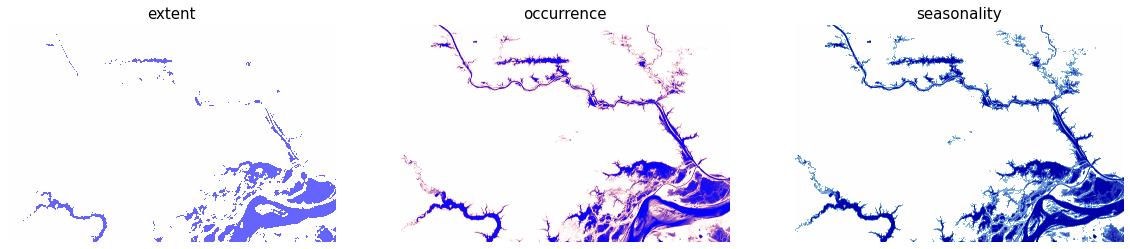

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 15))

for i, asset_key in enumerate(assets_of_interest):
    ax[i].imshow(data.sel(band=asset_key), norm=Normalize(0, 255), cmap=cmaps[asset_key])
    ax[i].set_title(asset_key, fontdict={"fontsize": 15})
    ax[i].set_axis_off()

plt.show()

## Proximity Distance

The `xrspatial.proximity` function operates on a given values aggregate to produce a new distance aggregate based on a set of target values and using a distance metric. The metric is used to calculate the distance at each each array cell (pixel) in the values aggregate from the nearest of the target points. For `proximity`, this smallest distance is set as each cell's value in the returned aggregate.

A powerful feature of `proximity` is that you can target specific points, the `target_values` parameter, in the aggregate for distance calculation and ignore the rest. By default, all non-zero pixels are set as targets. 

In this example, we'll calculate proximity distance using Great Circle distance metric for the Global Surface Water Dataset's Seasonality data. As default, all non-zero pixels will be our targets.

In [8]:
extent_proximity = proximity(
    data.sel(band="extent"), distance_metric='EUCLIDEAN'
)

extent_proximity.name = 'Water Extent proximity distance (Euclidean)'

In [9]:
# helper function to plot images
def plot_imgs(asset_data, asset_cmap, asset_norm, asset_name, proximity_img, proximity_cmap='Greens'):    
    fig = plt.figure(frameon=False, figsize=(15, 10))
    
    fig.add_subplot(121)
    plt.axis('off')    
    img = plt.imshow(asset_data, norm=asset_norm, cmap=asset_cmap)
    plt.title(asset_name)
    
    fig.add_subplot(122)
    plt.axis('off')        
    im2 = plt.imshow(proximity_img, cmap=proximity_cmap)
    im1 = plt.imshow(asset_data, norm=asset_norm, cmap=asset_cmap, alpha=0.5)
    plt.title(proximity_img.name)
    
    plt.show() 

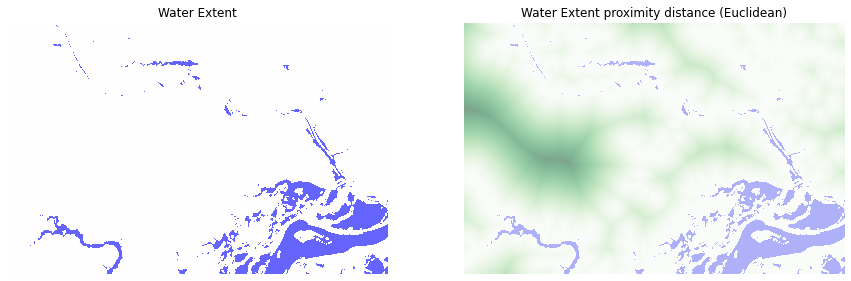

In [10]:
plot_imgs(
    asset_data=data.sel(band="extent"),
    asset_cmap=cmaps["extent"],
    asset_norm=Normalize(0, 255),
    asset_name='Water Extent',
    proximity_img=extent_proximity,
)

Note the brighter areas nearer the target points.

## Proximity Allocation

Similar to `xrspatial.proximity`, the `xrspatial.allocation` function operates on an aggregate and finds the smallest distance from each cell to any one of the target, or source, points. But, instead of the distance, it returns the value at that source point and sets the current cell to that value. So, the result is a raster with block areas, with all cells in each area set to the value of that area's nearest source.

In the same way as for `proximity`, we can set the target points with the `target_values` parameter. Let's apply allocation to the Global Surface Water Dataset's Maximum Water Extent data using euclidean distance, leaving the default all target points active.

In [11]:
occurrence_allocation = allocation(
    data.sel(band="occurrence"),
    distance_metric='GREAT_CIRCLE'
)

occurrence_allocation.name = 'Water Occurrence proximity allocation (Great Circle)'

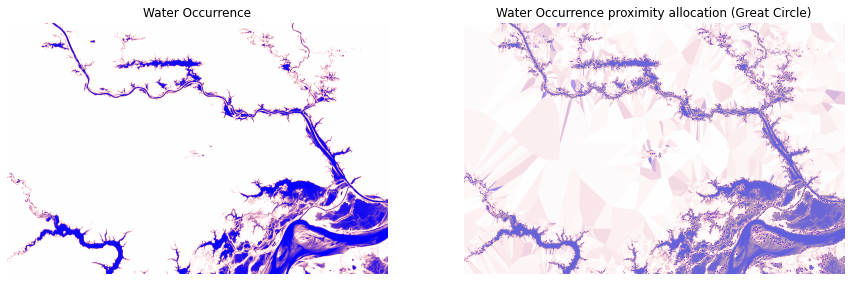

In [12]:
plot_imgs(
    asset_data=data.sel(band="occurrence"),
    asset_cmap=cmaps["occurrence"],
    asset_norm=Normalize(0, 255),
    asset_name='Water Occurrence',
    proximity_img=occurrence_allocation,
    proximity_cmap=cmaps["occurrence"]
)

Notice the blocks: each of the differently shaded blocks contains all of the points that have the target point in the center as their nearest target point.

## Proximity Direction

Also similar to `xrspatial.proximity`, `xrspatial.direction` also starts by calculating the smallest distance for each cell to a source point. But, instead of distance, it returns the direction in degrees to that nearest source point. The output values range from 0 to 360:
- 0 is for the source cell itself
- 90 is the east
- 180 is the south
- 270 is the west
- 360 is the north

You'll use the Global Surface Water Dataset's Water Occurance data calculate the proximity direction of areas that have water for 1 month and compare that to the proximity direction of areas that have 12 months water occurance.

Set `target_values` to `[1]` to indicate that direction will be calculated from pixels with a value of 1, which represents for 1-month.

In [13]:
seasonality_direction_1m = direction(
    data.sel(band="seasonality"),
    distance_metric='MANHATTAN',
    target_values=[1]
)        

seasonality_direction_1m.name = 'Water Seasonality (1 months) proximity direction (Manhattan)'

To better visualization all targets, let's filter out non-target pixels.

In [14]:
# for display purpose only
seasonality_1m = copy.deepcopy(data.sel(band="seasonality"))
seasonality_1m.data[seasonality_1m.data != 1] = 0

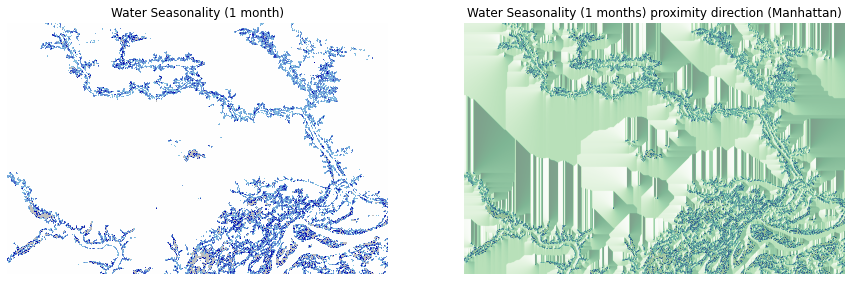

In [15]:
plot_imgs(
    asset_data=seasonality_1m,
    asset_cmap=cmaps["seasonality"],
    asset_norm=None,
    asset_name='Water Seasonality (1 month)',
    proximity_img=seasonality_direction_1m,
)

Similarly, we calculate direction to 12-month water occurance by specifying `target_values=[12]`.

In [16]:
seasonality_direction_12m = direction(
    data.sel(band="seasonality"),
    distance_metric='MANHATTAN',
    target_values=[12]
)                

seasonality_direction_12m.name = 'Water Seasonality (12 months) proximity direction (Manhattan)'

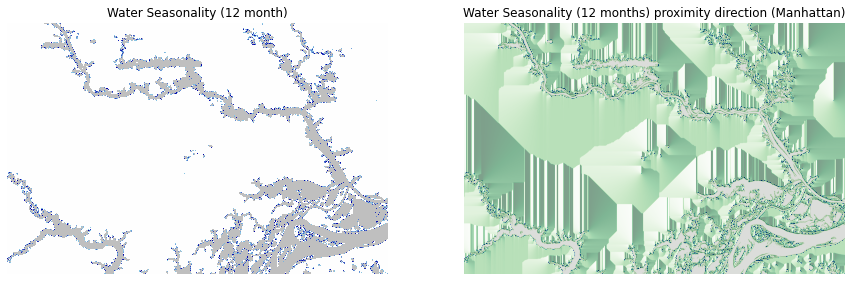

In [17]:
# for display purpose only
seasonality_12m = copy.deepcopy(data.sel(band="seasonality"))
seasonality_12m.data[seasonality_12m.data != 12] = 0

plot_imgs(
    asset_data=seasonality_12m,
    asset_cmap=cmaps["seasonality"],
    asset_norm=None,
    asset_name='Water Seasonality (12 month)',
    proximity_img=seasonality_direction_12m,
)